# Self Case Study  One

## MPST Dataset (Solving the MPST Research Paper) 

### Made by rnaidu1427@gmail.com / L Rohan 

## References

- https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff

- https://www.analyticsvidhya.com/blog/2019/04/predicting-movie-genres-nlp-multi-label-classification/

- https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

- https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

- https://pypi.org/project/sentic/

- https://www.guru99.com/tokenize-words-sentences-nltk.html

- https://www.datacamp.com/community/tutorials/stemming-lemmatization-python

- https://www.geeksforgeeks.org/generating-word-cloud-python/

- https://stackoverflow.com/questions/12632992/gridsearch-for-an-estimator-inside-a-onevsrestclassifier/12637528

- https://medium.com/@gabrielziegler3/multiclass-multilabel-classification-with-xgboost-66195e4d9f2d

## Reserach Paper

- https://www.kaggle.com/cryptexcode/mpst-movie-plot-synopses-with-tags

- https://www.aclweb.org/anthology/L18-1274/

- http://ritual.uh.edu/mpst-2018/

## Citation

@InProceedings{KAR18.332, author = {Sudipta Kar and Suraj Maharjan and A. Pastor López-Monroy and Thamar Solorio}, title = {{MPST}: A Corpus of Movie Plot Synopses with Tags}, booktitle = {Proceedings of the Eleventh International Conference on Language Resources and Evaluation (LREC 2018)}, year = {2018}, month = {May}, date = {7-12}, location = {Miyazaki, Japan}, editor = {Nicoletta Calzolari (Conference chair) and Khalid Choukri and Christopher Cieri and Thierry Declerck and Sara Goggi and Koiti Hasida and Hitoshi Isahara and Bente Maegaard and Joseph Mariani and Hélène Mazo and Asuncion Moreno and Jan Odijk and Stelios Piperidis and Takenobu Tokunaga}, publisher = {European Language Resources Association (ELRA)}, address = {Paris, France}, isbn = {979-10-95546-00-9}, language = {english} }

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import seaborn as sns
import numpy as np
from wordcloud import WordCloud, STOPWORDS
from datetime import datetime
from prettytable import PrettyTable
import re
from datetime import datetime
from sentic import SenticPhrase
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import pickle
from scipy.sparse import coo_matrix, hstack
from xgboost import XGBClassifier
import warnings
import seaborn as sns
warnings.filterwarnings('ignore')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to C:\Users\Rohan
[nltk_data]     Naidu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Rohan
[nltk_data]     Naidu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Rohan
[nltk_data]     Naidu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [19]:
df = pd.read_csv('mpst_full_data.csv')

df.head()

,imdb_id,title,plot_synopsis,tags,split,synopsis_source
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",train,imdb
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,train,imdb
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,test,imdb
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",train,imdb
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",val,imdb


In [20]:
print('Shape of our dataset: ', df.shape)

Shape of our dataset:  (14828, 6)


In [21]:
print('Column names in our dataset: ', df.columns.values)

Column names in our dataset:  ['imdb_id' 'title' 'plot_synopsis' 'tags' 'split' 'synopsis_source']


In [22]:
tag_ls = df.tags

tag_ls[0]

'cult, horror, gothic, murder, atmospheric'

In [23]:
zero_tags = 0
for tags in tag_ls:
    if len(tags) == 0:
        zero_tags += 1
        
print('Number of rows with zero tags: ', zero_tags)

Number of rows with zero tags:  0


In [24]:
# converting all tags from strings into list of strings 
genres = []
for tag in tag_ls:
    genres.append(tag.split(','))
    
print('After converting tags into list of strings: ', genres[0])

After converting tags into list of strings:  ['cult', ' horror', ' gothic', ' murder', ' atmospheric']


In [31]:
# converting list of tags back to string of tags with ',' for future use
# we can directly use df.tags also in the future to set the same tags in the df
# but for practice i've created this list

back_to_string = []
for genre in genres:
    ls_w = ','.join(genre)
    back_to_string.append(ls_w)

In [8]:
# creating a new column in the dataframe with new tags
movie_df = df.drop(columns=['tags'], axis=1)
movie_df['tags'] = genres
movie_df.head()

,imdb_id,title,plot_synopsis,split,synopsis_source,tags
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,train,imdb,"[cult, horror, gothic, murder, atmospheric]"
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",train,imdb,[violence]
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",test,imdb,[romantic]
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...",train,imdb,"[inspiring, romantic, stupid, feel-good]"
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (A...",val,imdb,"[cruelty, murder, dramatic, cult, violence..."


In [9]:
movie_df_duplicated = movie_df[movie_df.duplicated(['imdb_id', 'title', 'plot_synopsis', 'split', 
                                              'synopsis_source'])]

In [10]:
print('Number of duplicated rows: ', movie_df_duplicated.shape[0])

Number of duplicated rows:  0


In [11]:
# a single list of all the tags
all_tags = sum(genres, [])

print('Number of unique tags in our dataset: ', len(set(all_tags)))

Number of unique tags in our dataset:  142


In [12]:
# plotting top 50 tags in descensing order based on their count in the dataset

all_tags_count = nltk.FreqDist(all_tags)  # returns a dict

all_tags_df = pd.DataFrame({'Tag': list(all_tags_count.keys()), 'Count': list(all_tags_count.values())})

print('Each Tag and it\'s count in the dataset:\n')
all_tags_df.head()

Each Tag and it's count in the dataset:



,Tag,Count
0,cult,1033
1,horror,408
2,gothic,332
3,murder,4344
4,atmospheric,381


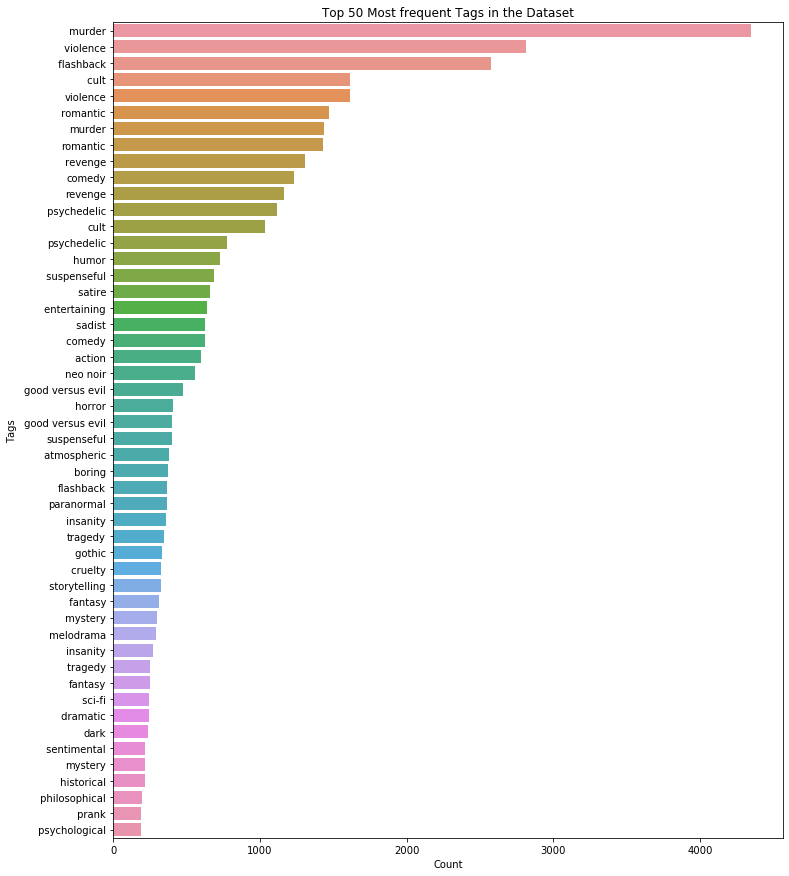

In [13]:
tags_descending = all_tags_df.nlargest(n = 50, columns="Count") 

plt.figure(figsize=(12,15)) 
ax = sns.barplot(data=tags_descending, x = "Count", y = "Tag") 
ax.set(ylabel = 'Tags') 
ax.set_title('Top 50 Most frequent Tags in the Dataset')
plt.show()

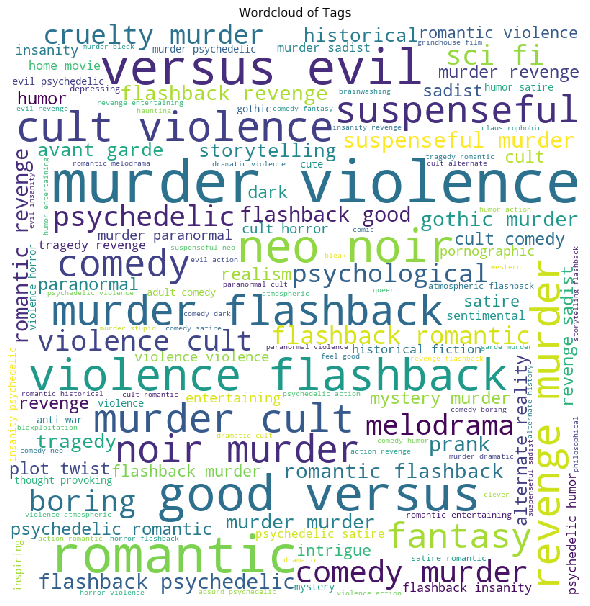

In [14]:
# plotting a wordcloud of tags 

comment_words = ' '
stopwords = set(STOPWORDS) 

tokens = all_tags

for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
        
for words in tokens: 
    comment_words = comment_words + words + ' '

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words)

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title('Wordcloud of Tags')
plt.show() 

## Observations- 

- we can see from the word cloud and frequency plot that words like romantic, violance, flashback etc are the most frequent words in our tag set
- this gives us an understanding of what kinda movies are more frequent in our whole MPST dataset

In [15]:
tags_arr = all_tags_df.Count.values
idx = np.argmax(tags_arr)

print('Most frequent Tag in the dataset, {0}: {1}'.format(all_tags_df.Tag[idx], all_tags_df.Count[idx]))

Most frequent Tag in the dataset,  murder: 4344


In [16]:
tags_arr = all_tags_df.Count.values
idx = np.argmin(tags_arr)

print('Least frequent Tag in the dataset, {0}: {1}'.format(all_tags_df.Tag[idx], all_tags_df.Count[idx]))

Least frequent Tag in the dataset, claustrophobic: 3


In [17]:
# Now analysing tags per movie instead of the whole dataset
# genres consists of list of tags for each movie so we can use this

len_of_tags = []
for movie_tags in genres:
    len_of_tags.append(len(movie_tags))

s = list(set(len_of_tags))

print('Lowest number of tags for a movie: ', min(s))
print('Highest number of tags for a movie: ', max(s))

Lowest number of tags for a movie:  1
Highest number of tags for a movie:  25


In [18]:
print('Average Tags per movie: ', round(np.average(len_of_tags), 2))

Average Tags per movie:  2.98


In [19]:
print('Median value of Tags per movie: ', np.median(len_of_tags))

Median value of Tags per movie:  2.0


In [20]:
print('STD Tags for a movie : ', round(np.std(len_of_tags), 2))

STD Tags for a movie :  2.6


In [21]:
plots = movie_df.plot_synopsis.values
tokens = sent_tokenize(plots[0])

print('Number of sentences in the first movie plot: ', len(tokens))
print('First sentence in the first movie plot: \n\n', tokens[0])

Number of sentences in the first movie plot:  57
First sentence in the first movie plot: 

 Note: this synopsis is for the orginal Italian release with the segments in this certain order.Boris Karloff introduces three horror tales of the macabre and the supernatural known as the 'Three Faces of Fear'.THE TELEPHONERosy (Michele Mercier) is an attractive, high-priced Parisian call-girl who returns to her spacious, basement apartment after an evening out when she immediately gets beset by a series of strange phone calls.


In [22]:
# performing EDA on sentences 
start = datetime.now()
len_plot_sents = []
for plot in movie_df.plot_synopsis:
    len_plot_sents.append(len(sent_tokenize(plot)))

print('Number of plots sent tokenized: ', len(len_plot_sents))
print('\nTime taken: ', datetime.now() - start)

Number of plots sent tokenized:  14828

Time taken:  0:00:51.243895


In [23]:
print('Average number of sentences for all plots: ', round(np.average(len_plot_sents), 2))

Average number of sentences for all plots:  43.58


In [24]:
print('Median number of sentences for all plot: ', np.median(len_plot_sents))

Median number of sentences for all plot:  32.0


In [25]:
print('STD of sentences for all plots: ', round(np.std(len_plot_sents), 2))

STD of sentences for all plots:  47.48


In [26]:
print('Highest number of sentences in all plots: ', max(len_plot_sents))

Highest number of sentences in all plots:  1434


In [27]:
print('Lowest number of sentences in all plots: ', min(len_plot_sents))

Lowest number of sentences in all plots:  10


In [28]:
# word tokenize 
plots = movie_df.plot_synopsis.values
tokens = word_tokenize(plots[0])

print('Number of words in the first movie plot: ', len(tokens))
print('First 5 words in the first movie plot: ', tokens[:5])

Number of words in the first movie plot:  1484
First 5 words in the first movie plot:  ['Note', ':', 'this', 'synopsis', 'is']


In [29]:
# performing EDA on words
start = datetime.now()
len_plot_words = []
for plot in movie_df.plot_synopsis:
    len_plot_words.append(len(word_tokenize(plot)))

print('Number of plots word tokenized: ', len(len_plot_words))
print('\nTime taken: ', datetime.now() - start)

Number of plots word tokenized:  14828

Time taken:  0:03:21.847502


In [30]:
print('Average number of words for all plots: ', round(np.average(len_plot_words), 2))

Average number of words for all plots:  1028.62


In [31]:
print('Median number of words for all plots: ', np.median(len_plot_words))

Median number of words for all plots:  759.0


In [32]:
print('Highest number of words for all plots: ', max(len_plot_words))

Highest number of words for all plots:  14966


In [33]:
print('STD of words for all plots: ', round(np.std(len_plot_words), 2))

STD of words for all plots:  1010.04


In [34]:
print('Lowest number of words for all plots: ', min(len_plot_words))

Lowest number of words for all plots:  91


In [13]:
# preprocessing
stop_words = set(stopwords.words('english'))
def preprocess_text(text):
    '''
        simple function to preprocess whichever text given 
    '''
    # remove whitespaces 
    text = ' '.join(text.split()) 
    # convert text to lowercase 
    text = text.lower() 
    
    #phrases
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    
    # remove everything except alphabets 
    text = re.sub("[^a-zA-Z]"," ",text) 
    
    # removing stopwards
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    text =  ' '.join(no_stopword_text)
    
    return text

In [38]:
ls = movie_df.plot_synopsis.values
prep_text = preprocess_text(ls[0])

print('Before Preprocessing: \n\n', ls[0])
print()
print('='* 138)
print()
print('After preprocessing: \n\n', prep_text)

Before Preprocessing: 

 Note: this synopsis is for the orginal Italian release with the segments in this certain order.Boris Karloff introduces three horror tales of the macabre and the supernatural known as the 'Three Faces of Fear'.THE TELEPHONERosy (Michele Mercier) is an attractive, high-priced Parisian call-girl who returns to her spacious, basement apartment after an evening out when she immediately gets beset by a series of strange phone calls. The caller soon identified himself as Frank, her ex-pimp who has recently escaped from prison. Rosy is terrified for it was her testimony that landed the man in jail. Looking for solace, Rosy phones her lesbian lover Mary (Lynda Alfonsi). The two women have been estranged for some time, but Rosy is certain that she is the only one who can help her. Mary agrees to come over that night. Seconds later, Frank calls again, promising that no matter who she calls for protection, he will have his revenge. Unknown to Rosy, Mary is the caller impe

In [14]:
movie_df['plot_synopsis'] = movie_df.plot_synopsis.apply(lambda x: preprocess_text(x))

In [15]:
movie_df.head()

,imdb_id,title,plot_synopsis,split,synopsis_source,tags
0,tt0057603,I tre volti della paura,note synopsis orginal italian release segments...,train,imdb,"[cult, horror, gothic, murder, atmospheric]"
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,two thousand years ago nhagruul foul sorcerer ...,train,imdb,[violence]
2,tt0033045,The Shop Around the Corner,matuschek gift store budapest workplace alfred...,test,imdb,[romantic]
3,tt0113862,Mr. Holland's Opus,glenn holland morning person anyone standards ...,train,imdb,"[inspiring, romantic, stupid, feel-good]"
4,tt0086250,Scarface,may cuban man named tony montana al pacino cla...,val,imdb,"[cruelty, murder, dramatic, cult, violence..."


In [2]:
# storing our final movie dataframe into pickle 
# then loading it 
# movie_df.to_pickle('movie_df.pkl')

movie_df = pd.read_pickle('movie_df.pkl')
movie_df.head()

,imdb_id,title,plot_synopsis,split,synopsis_source,tags
0,tt0057603,I tre volti della paura,note synopsis orginal italian release segments...,train,imdb,"[cult, horror, gothic, murder, atmospheric]"
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,two thousand years ago nhagruul foul sorcerer ...,train,imdb,[violence]
2,tt0033045,The Shop Around the Corner,matuschek gift store budapest workplace alfred...,test,imdb,[romantic]
3,tt0113862,Mr. Holland's Opus,glenn holland morning person anyone standards ...,train,imdb,"[inspiring, romantic, stupid, feel-good]"
4,tt0086250,Scarface,may cuban man named tony montana al pacino cla...,val,imdb,"[cruelty, murder, dramatic, cult, violence..."


In [41]:
def freq_words(x, terms):
    '''
        shows most frequent no of(terms) words in the plot synopsis  
    '''
    all_words = ' '.join([text for text in x]) 
    all_words = all_words.split() 
    fdist = nltk.FreqDist(all_words) 
    words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())}) 
    
    # selecting top 20 most frequent words 
    d = words_df.nlargest(columns="count", n = terms) 
    
    # visualize words and frequencies
    plt.figure(figsize=(12,15)) 
    ax = sns.barplot(data=d, x= "count", y = "word") 
    ax.set(ylabel = 'Word')
    plt.title('Most frequent words in plot synopsis')
    plt.show()

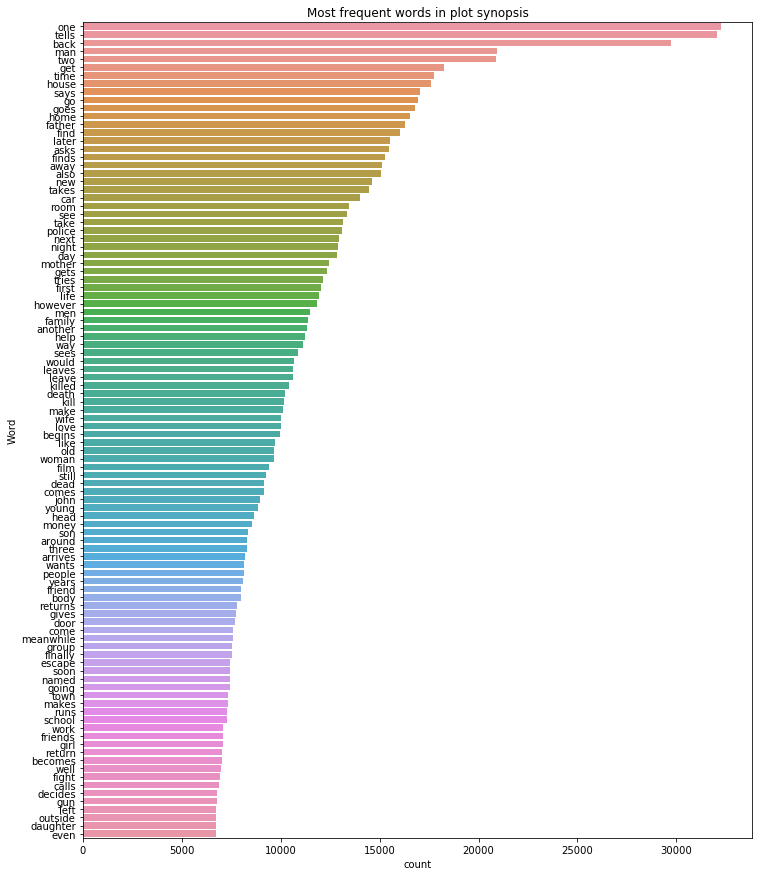

In [42]:
freq_words(movie_df.plot_synopsis, 100)

## Observations-

- We can see the words like one, tells, back are the most frequent words in our plot synopsis
- note that stop words are already removed before analysing word frequencies

In [43]:
# Label Density 
n_unique_tags = len(set(all_tags))
LD_ls = []
for movie_tags in genres:
    LD_ls.append(len(movie_tags) / n_unique_tags)

label_density =  np.average(LD_ls)
print('Label Density of our Dataset is: ', round(label_density, 3))

Label Density of our Dataset is:  0.021


In [44]:
x = PrettyTable()

x.field_names = ["Analysis of Tags", "Values"]

x.add_row(["Total plot synopses", movie_df.shape[0]])
x.add_row(["Total tags", n_unique_tags])
x.add_row(["Average tags per movie", round(np.average(len_of_tags), 2)])
x.add_row(["Median value of tags per movie", np.median(len_of_tags)])
x.add_row(["STD of tags for a movie", round(np.std(len_of_tags), 2)])
x.add_row(["Lowest number of tags for a movie", min(s)])
x.add_row(["Highest number of tags for a movie", max(s)])

print(x)

+------------------------------------+--------+
|          Analysis of Tags          | Values |
+------------------------------------+--------+
|        Total plot synopses         | 14828  |
|             Total tags             |  142   |
|       Average tags per movie       |  2.98  |
|   Median value of tags per movie   |  2.0   |
|      STD of tags for a movie       |  2.6   |
| Lowest number of tags for a movie  |   1    |
| Highest number of tags for a movie |   25   |
+------------------------------------+--------+


In [45]:
x = PrettyTable()

x.field_names = ["Analysis of Sentences", "Values"]

x.add_row(["Average number of sentences for movies", round(np.average(len_plot_sents), 2)])
x.add_row(["Median value of sentences for movies", np.median(len_plot_sents)])
x.add_row(["STD of sentences for a movie", round(np.std(len_plot_sents), 2)])
x.add_row(["Lowest number of sentences for all movies", min(len_plot_sents)])
x.add_row(["Highest number of sentences for all movies", max(len_plot_sents)])

print(x)

+--------------------------------------------+--------+
|           Analysis of Sentences            | Values |
+--------------------------------------------+--------+
|   Average number of sentences for movies   | 43.58  |
|    Median value of sentences for movies    |  32.0  |
|        STD of sentences for a movie        | 47.48  |
| Lowest number of sentences for all movies  |   10   |
| Highest number of sentences for all movies |  1434  |
+--------------------------------------------+--------+


In [46]:
x = PrettyTable()

x.field_names = ["Analysis of words", "Values"]

x.add_row(["Average number of words for movies", round(np.average(len_plot_words), 2)])
x.add_row(["Median value of words for movies", np.median(len_plot_words)])
x.add_row(["STD of words for a movie", round(np.std(len_plot_words), 2)])
x.add_row(["Lowest number of words for all movies", min(len_plot_words)])
x.add_row(["Highest number of words for all movies", max(len_plot_words)])

print(x)

+----------------------------------------+---------+
|           Analysis of words            |  Values |
+----------------------------------------+---------+
|   Average number of words for movies   | 1028.62 |
|    Median value of words for movies    |  759.0  |
|        STD of words for a movie        | 1010.04 |
| Lowest number of words for all movies  |    91   |
| Highest number of words for all movies |  14966  |
+----------------------------------------+---------+


In [47]:
def text_split(synopsis):
    '''
        gets the text split for emotion plot, only takes 8 splits
    '''
    text = synopsis.split(' ')
    size = int(len(text)/8)
    t_1 = ' '.join(w for w in text[0:size])
    t_2 = ' '.join(w for w in text[size:size*2])
    t_3 = ' '.join(w for w in text[size*2:size*3])
    t_4 = ' '.join(w for w in text[size*3:size*4])
    t_5 = ' '.join(w for w in text[size*4:size*5])
    t_6 = ' '.join(w for w in text[size*5:size*6])
    t_7 = ' '.join(w for w in text[size*6:size*7])
    t_8 = ' '.join(w for w in text[size*7:])
    
    return t_1, t_2, t_3, t_4, t_5, t_6, t_7, t_8 

In [48]:
def get_emotions(synopsis):
    '''
        gets the emotions of a plot synopsis
    '''
    text_1, text_2, text_3, text_4, text_5, text_6, text_7, text_8 = text_split(synopsis)

    anger = []
    joy = []
    interest = []
    disgust = []
    sadness = []
    fear = []
    for text in [text_1, text_2, text_3, text_4, text_5, text_6, text_7, text_8]:
        sp = SenticPhrase(text)
        dic_tags = sp.get_moodtags()
        anger.append(dic_tags.get('#anger'))
        joy.append(dic_tags.get('#joy'))
        fear.append(dic_tags.get('#fear'))
        disgust.append(dic_tags.get('#disgust'))
        sadness.append(dic_tags.get('#sadness'))
        interest.append(dic_tags.get('#interest'))
    
    return anger, joy, fear, disgust, sadness, interest

In [49]:
def plot_emotions(synopsis):
    '''
        plotting emotions of a plot synopsis
    '''
    plot_anger, plot_joy, plot_fear, plot_disgust, plot_sadness, plot_interest = get_emotions(synopsis)
    
    ls = [i for i in range(8)]
    plt.figure(figsize=(7, 6))
    plt.plot(ls, plot_anger, label='Anger')
    plt.scatter(ls, plot_anger)
    plt.plot(ls, plot_joy, label='Joy')
    plt.scatter(ls, plot_joy)
    plt.plot(ls, plot_fear, label='Fear')
    plt.scatter(ls, plot_fear)
    plt.plot(ls, plot_disgust, label='Disgust')
    plt.scatter(ls, plot_disgust)
    plt.plot(ls, plot_sadness, label='Sadness')
    plt.scatter(ls, plot_sadness)
    plt.plot(ls, plot_interest, label='Interest')
    plt.scatter(ls, plot_interest)
    plt.title("Flow of emotions")
    plt.xlabel("Plot Chunks")
    plt.ylabel('Mood values')
    plt.legend(loc='best')
    plt.show()

Title:  Scarface

Tags:  ['cruelty', ' murder', ' dramatic', ' cult', ' violence', ' atmospheric', ' action', ' romantic', ' revenge', ' sadist']

Emotion Plot: 



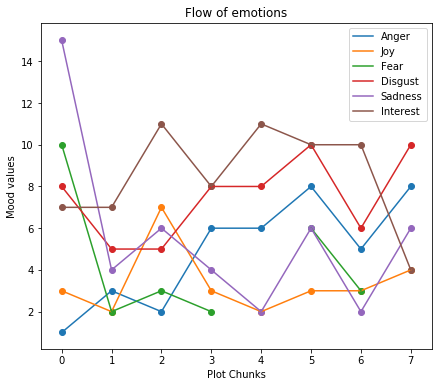

In [50]:
print('Title: ', movie_df.title[4])
print()
print('Tags: ', movie_df.tags[4])
print()
print('Emotion Plot: \n')
plot_emotions(movie_df.plot_synopsis[4])

Title:  The Dark Knight Rises

Tags:  ['dark', ' suspenseful', ' neo noir', ' murder', ' fantasy', ' cult', ' violence', ' atmospheric', ' flashback', ' good versus evil', ' plot twist', ' psychedelic', ' revenge']

Emotion Plot: 



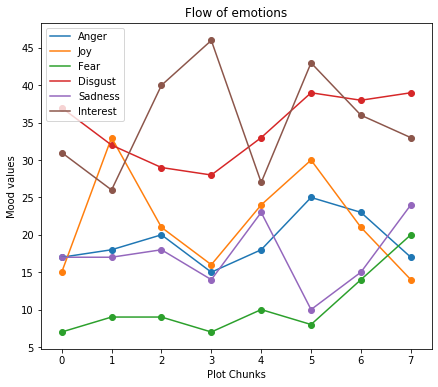

In [51]:
print('Title: ', movie_df.title[4794])
print()
print('Tags: ', movie_df.tags[4794])
print()
print('Emotion Plot: \n')
plot_emotions(movie_df.plot_synopsis[4794])

## Observations-

- I have taken these two movie plot synopsis specifically as they contains a lot of words
- we can see the diffrence in emotions as the movie plot or story of the movie progresses
- Ex: in the movie "The Dark Knight Rises", fear is pretty low in the beginning but as the movie progrsses fear keeps on increasing in the movie
- this is the flow of emotions which a movie produces as the movie goes one

## Featurization  

In [3]:
#train test split 

X_train = movie_df.loc[(movie_df.split == 'train') | (movie_df.split == 'val')]
X_test = movie_df.loc[(movie_df.split == 'test')]

In [4]:
X_train.head()

,imdb_id,title,plot_synopsis,split,synopsis_source,tags
0,tt0057603,I tre volti della paura,note synopsis orginal italian release segments...,train,imdb,"[cult, horror, gothic, murder, atmospheric]"
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,two thousand years ago nhagruul foul sorcerer ...,train,imdb,[violence]
3,tt0113862,Mr. Holland's Opus,glenn holland morning person anyone standards ...,train,imdb,"[inspiring, romantic, stupid, feel-good]"
4,tt0086250,Scarface,may cuban man named tony montana al pacino cla...,val,imdb,"[cruelty, murder, dramatic, cult, violence..."
5,tt1315981,A Single Man,george falconer colin firth approaches car acc...,val,imdb,"[romantic, queer, flashback]"


In [5]:
# one hot encoding tags

multilabel_binarizer = MultiLabelBinarizer()
y_train = multilabel_binarizer.fit_transform(X_train['tags'])
y_test = multilabel_binarizer.transform(X_test['tags'])

In [6]:
print('Current shape of X_train: {0}, y_train: {1}'.format(X_train.shape, y_train.shape))
print('Current shape of X_test: {0}, y_test: {1}'.format(X_test.shape, y_test.shape))

Current shape of X_train: (11862, 6), y_train: (11862, 142)
Current shape of X_test: (2966, 6), y_test: (2966, 142)


### SenticPhrase Features 

## Observations-

- I am only taking 2 chunk features and not like 8 chunks shown in the EDA
- the reason behind that is due to fact that each plot synopsis does not contain as many words like the one shown in the EDA
- so there is no point taking 8 chunks as the rest of the chunks will return None during Sentic Analysis

<img src='chunks.png'>

In [7]:
def text_split_features(synopsis):
    '''
        gets the text split for emotion plot, only takes 2 splits
    '''
    text = synopsis.split(' ')
    size = int(len(text)/2)
    t_1 = ' '.join(w for w in text[0:size])
    t_2 = ' '.join(w for w in text[size:size*2])
    
    return t_1, t_2

In [8]:
def get_chunk_sentics(synopsis):
    '''
        gets the emotions of a plot synopsis in chunks
    '''
    text_1, text_2 = text_split_features(synopsis)
    
    vecs = []
    for text in [text_1, text_2]:
        sp = SenticPhrase(text)
        di_sentics = sp.get_sentics()
        di_moodtags = sp.get_moodtags()
        
        all_tags = list(di_moodtags.keys())
        
        polarity = sp.get_polarity()
        vect = np.zeros(13,dtype = float)
        
        if dict_sentics.get('pleasantness') != None:
            vect[0] = float(dict_sentics.get('pleasantness'))
        else:
            vect[0] = 0
        if dict_sentics.get('attention') != None:
            vect[1] = float(dict_sentics.get('attention'))
        else:
            vect[1] = 0
        if dict_sentics.get('sensitivity') != None:
            vect[2] = float(dict_sentics.get('sensitivity'))
        else:
            vect[2] = 0
        if dict_sentics.get('aptitude') != None:
            vect[3] = float(dict_sentics.get('aptitude'))
        else:
            vect[3] = 0
        if '#anger' in all_tags:
            vect[4] = float(dict_moodtags.get('#anger'))
        else:
            vect[4] = 0
        if '#admiration' in all_tags:
            vect[5] = float(dict_moodtags.get('#admiration'))
        else:
            vect[5] = 0
        if '#joy' in all_tags:
            vect[6] = float(dict_moodtags.get('#joy'))
        else:
            vect[6] = 0
        if '#interest' in all_tags:
            vect[7] = float(dict_moodtags.get('#interest'))
        else:
            vect[7] = 0
        if '#disgust' in all_tags:
            vect[8] = float(dict_moodtags.get('#disgust'))
        else:
            vect[8] = 0
        if '#sadness' in all_tags:
            vect[9] = float(dict_moodtags.get('#sadness'))
        else:
            vect[9] = 0
        if '#surprise' in all_tags:
            vect[10] = float(dict_moodtags.get('#surprise'))
        else:
            vect[10] = 0
        if '#fear' in all_tags:
            vect[11] = float(dict_moodtags.get('#fear'))
        else:
            vect[11] = 0
            
        vect[12] = float(polarity)
        vecs.append(vect)
        
    vector = None
    for i in range(1):
        a = list(vecs[0])
        a.extend(list(vecs[1]))
        vector = np.array(a)
#     final_vect = vector.reshape(1, -1)
#     print(b)
#     print('\n')
#     print(b.shape)
    return vector

In [9]:
start = datetime.now()
train_plot = X_train.plot_synopsis.values
test_plot = X_test.plot_synopsis.values
tr_arr = []
for i in range(len(train_plot)):
    row = train_plot[i]
    ve = get_chunk_sentics(row)
    tr_arr.append(ve)
    
te_arr = []
for j in range(len(test_plot)):
    row = test_plot[j]
    ve = get_chunk_sentics(row)
    te_arr.append(ve)
    
X_train_sent = np.array(tr_arr)
X_test_sent = np.array(te_arr)

print('X_train shape: {0} y_train shape: {1}'.format(X_train_sent.shape, y_train.shape))
print('X_test shape: {0} y_test shape: {1}'.format(X_test_sent.shape, y_test.shape))
print('\nTime taken: ', datetime.now() - start)

X_train shape: (11862, 26) y_train shape: (11862, 142)
X_test shape: (2966, 26) y_test shape: (2966, 142)

Time taken:  0:03:40.398632


### Tfidf Features 

- before doing tfidf we haven't performed stemming and lemmatization for our plot synopsis 
- it wasn't done due to our emotion features now since we have our emotion features we can do stemming and 
lemmatization and continue with our featurization

In [29]:
def stem(text):
    '''
        we are using porter stemmer to perform stemming for plot synopsis
    '''
    porter = PorterStemmer()
    token_words = word_tokenize(text)
    stem_sentence = []
    for word in token_words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    
    return "".join(stem_sentence)
    

In [41]:
def lemma(text):
    '''
        we are using wordnet lemmatizer for our plot synopsis
    '''
    wordnet_lemmatizer = WordNetLemmatizer()
    token_words = word_tokenize(text)
    lemma_sentence = []
    for word in token_words:
        lemma_sentence.append(wordnet_lemmatizer.lemmatize(word))
        lemma_sentence.append(" ")
        
    return "".join(lemma_sentence)

In [36]:
stemmed = stem(movie_df.plot_synopsis[0])
print('Before Stemming: \n\n', movie_df.plot_synopsis[0])
print('\n')
print('='*120)
print('\n')
print('After Stemming: \n\n', stemmed)

Before Stemming: 

 note synopsis orginal italian release segments certain order boris karloff introduces three horror tales macabre supernatural known nothree faces fear telephonerosy michele mercier attractive high priced parisian call girl returns spacious basement apartment evening immediately gets beset series strange phone calls caller soon identified frank ex pimp recently escaped prison rosy terrified testimony landed man jail looking solace rosy phones lesbian lover mary lynda alfonsi two women estranged time rosy certain one help mary agrees come night seconds later frank calls promising matter calls protection revenge unknown rosy mary caller impersonating frank marry arrives rosy apartment soon best calm rosy nerves gives panic struck woman tranquillizer puts bed later night rosy sleeps mary gets bed pens note confession one making strange phone calls learned franks escape prison knowing rosy would call help explains felt way coming back life breakup busy writing fails noti

In [37]:
# now performing stemming on all our plot_synopsis
start = datetime.now()
movie_df['plot_synopsis'] = movie_df.plot_synopsis.apply(lambda text: stem(text))

print(movie_df.head())
print('\nTime taken: ', datetime.now() - start)

     imdb_id                                          title  \
0  tt0057603                        I tre volti della paura   
1  tt1733125  Dungeons & Dragons: The Book of Vile Darkness   
2  tt0033045                     The Shop Around the Corner   
3  tt0113862                             Mr. Holland's Opus   
4  tt0086250                                       Scarface   

                                       plot_synopsis  split synopsis_source  \
0  note synopsi orgin italian releas segment cert...  train            imdb   
1  two thousand year ago nhagruul foul sorcer rev...  train            imdb   
2  matuschek gift store budapest workplac alfr kr...   test            imdb   
3  glenn holland morn person anyon standard woken...  train            imdb   
4  may cuban man name toni montana al pacino clai...    val            imdb   

                                                tags  
0    [cult,  horror,  gothic,  murder,  atmospheric]  
1                                   

In [44]:
# lemmatizing all our plot synopsis
start = datetime.now()
movie_df['plot_synopsis'] = movie_df.plot_synopsis.apply(lambda text: lemma(text))
print('\nTime taken: ', datetime.now() - start)


Time taken:  0:02:00.858680


In [45]:
# After stemming and lemmatization
movie_df.head()

,imdb_id,title,plot_synopsis,split,synopsis_source,tags
0,tt0057603,I tre volti della paura,note synopsi orgin italian releas segment cert...,train,imdb,"[cult, horror, gothic, murder, atmospheric]"
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,two thousand year ago nhagruul foul sorcer rev...,train,imdb,[violence]
2,tt0033045,The Shop Around the Corner,matuschek gift store budapest workplac alfr kr...,test,imdb,[romantic]
3,tt0113862,Mr. Holland's Opus,glenn holland morn person anyon standard woken...,train,imdb,"[inspiring, romantic, stupid, feel-good]"
4,tt0086250,Scarface,may cuban man name toni montana al pacino clai...,val,imdb,"[cruelty, murder, dramatic, cult, violence..."


## Observations-

- from the above plot synopsis, if we look at the first synopsis only, words like synopsis --> synopsi and release --> releas
- our stemming and lemmatization has been successful 

In [10]:
# now storing the stemmed and lemmatized synopsis datframe into a pickle file

# movie_df.to_pickle('movie_df_stem_lem.pkl')
movie_df_stem_lem = pd.read_pickle('movie_df_stem_lem.pkl')

movie_df_stem_lem.head()

,imdb_id,title,plot_synopsis,split,synopsis_source,tags
0,tt0057603,I tre volti della paura,note synopsi orgin italian releas segment cert...,train,imdb,"[cult, horror, gothic, murder, atmospheric]"
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,two thousand year ago nhagruul foul sorcer rev...,train,imdb,[violence]
2,tt0033045,The Shop Around the Corner,matuschek gift store budapest workplac alfr kr...,test,imdb,[romantic]
3,tt0113862,Mr. Holland's Opus,glenn holland morn person anyon standard woken...,train,imdb,"[inspiring, romantic, stupid, feel-good]"
4,tt0086250,Scarface,may cuban man name toni montana al pacino clai...,val,imdb,"[cruelty, murder, dramatic, cult, violence..."


## Observations-

- Now we can perform our Tfidf Vectorization
- before that we'll again do train test split

In [11]:
# train test split after stemming and lemmatization

X_train_s_l = movie_df_stem_lem.loc[(movie_df_stem_lem.split == 'train') | (movie_df_stem_lem.split == 'val')]
X_test_s_l = movie_df_stem_lem.loc[(movie_df_stem_lem.split == 'test')]

In [12]:
X_train_s_l.head()

,imdb_id,title,plot_synopsis,split,synopsis_source,tags
0,tt0057603,I tre volti della paura,note synopsi orgin italian releas segment cert...,train,imdb,"[cult, horror, gothic, murder, atmospheric]"
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,two thousand year ago nhagruul foul sorcer rev...,train,imdb,[violence]
3,tt0113862,Mr. Holland's Opus,glenn holland morn person anyon standard woken...,train,imdb,"[inspiring, romantic, stupid, feel-good]"
4,tt0086250,Scarface,may cuban man name toni montana al pacino clai...,val,imdb,"[cruelty, murder, dramatic, cult, violence..."
5,tt1315981,A Single Man,georg falcon colin firth approach car accid mi...,val,imdb,"[romantic, queer, flashback]"


In [13]:
print('Current shape of X_train: {0}, y_train: {1}'.format(X_train_s_l.shape, y_train.shape))
print('Current shape of X_test: {0}, y_test: {1}'.format(X_test_s_l.shape, y_test.shape))

Current shape of X_train: (11862, 6), y_train: (11862, 142)
Current shape of X_test: (2966, 6), y_test: (2966, 142)


## Observations-

- first i am going to try it with all the 142 tags and i am going to use simple Logistic Regression with one_vs_rest classifier
- in the research paper they are using only top 3 and 4 tags 
- the reason for that i'll tell in a while

<img src='log_regression.png'>

### Tfidf Unigram 

In [14]:
# tfidf vectorizer unigram
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=10, max_features=20000, norm="l2", \
                             tokenizer = lambda x: x.split(), ngram_range=(1,1))

X_train_uni = vectorizer.fit_transform(X_train_s_l.plot_synopsis.values)
X_test_uni = vectorizer.transform(X_test_s_l.plot_synopsis.values)

print('X_train shape: {0} y_train shape: {1}'.format(X_train_uni.shape, y_train.shape))
print('X_test shape: {0} y_test shape: {1}'.format(X_test_uni.shape, y_test.shape))
print('\nTime taken: ', datetime.now() - start)

X_train shape: (11862, 15706) y_train shape: (11862, 142)
X_test shape: (2966, 15706) y_test shape: (2966, 142)

Time taken:  0:00:03.672704


### Tfidf Bigram 

In [15]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=10, max_features=20000, norm="l2", \
                             tokenizer = lambda x: x.split(), ngram_range=(2,2))

X_train_bi = vectorizer.fit_transform(X_train_s_l.plot_synopsis.values)
X_test_bi = vectorizer.transform(X_test_s_l.plot_synopsis.values)

print('X_train shape: {0} y_train shape: {1}'.format(X_train_bi.shape, y_train.shape))
print('X_test shape: {0} y_test shape: {1}'.format(X_test_bi.shape, y_test.shape))
print('\nTime taken: ', datetime.now() - start)

X_train shape: (11862, 20000) y_train shape: (11862, 142)
X_test shape: (2966, 20000) y_test shape: (2966, 142)

Time taken:  0:00:21.693944


### Tfidf Trigram 

In [16]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=10, max_features=20000, norm="l2", \
                             tokenizer = lambda x: x.split(), ngram_range=(3,3))

X_train_tri = vectorizer.fit_transform(X_train_s_l.plot_synopsis.values)
X_test_tri = vectorizer.transform(X_test_s_l.plot_synopsis.values)

print('X_train shape: {0} y_train shape: {1}'.format(X_train_tri.shape, y_train.shape))
print('X_test shape: {0} y_test shape: {1}'.format(X_test_tri.shape, y_test.shape))
print('\nTime taken: ', datetime.now() - start)

X_train shape: (11862, 2390) y_train shape: (11862, 142)
X_test shape: (2966, 2390) y_test shape: (2966, 142)

Time taken:  0:00:33.544341


### Tfidf n-gram 

In [17]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=10, max_features=20000, norm="l2", \
                             tokenizer = lambda x: x.split(), ngram_range=(1,3))

X_train_n_gram = vectorizer.fit_transform(X_train_s_l.plot_synopsis.values)
X_test_n_gram = vectorizer.transform(X_test_s_l.plot_synopsis.values)

print('X_train shape: {0} y_train shape: {1}'.format(X_train_n_gram.shape, y_train.shape))
print('X_test shape: {0} y_test shape: {1}'.format(X_test_n_gram.shape, y_test.shape))
print('\nTime taken: ', datetime.now() - start)

X_train shape: (11862, 20000) y_train shape: (11862, 142)
X_test shape: (2966, 20000) y_test shape: (2966, 142)

Time taken:  0:01:04.010962


## Modelling

- Startegy for which models to choose is simple
- we have very large dimensionality of our models so we'll choose linear models as our first try 
- performance metric would be micro F1-Score 

### Logistic regression 

In [51]:
# training our LR with best params
def run_lr(x_train_data, y_train_data, x_test_data, y_test_data, best_param):
    '''
        running simple Logistic regression using OneVsRestClassifier
    '''
    clf_lr = OneVsRestClassifier(LogisticRegression(C=best_param, penalty='l2', class_weight="balanced"), 
                                 n_jobs=-1)
    clf_lr.fit(x_train_data, y_train_data)
    
    y_test_pred = clf_lr.predict(x_test_data)
    
    precision = precision_score(y_test_data, y_test_pred, average='micro')
    recall = recall_score(y_test_data, y_test_pred, average='micro')
    f1 = f1_score(y_test_data, y_test_pred, average='micro')
    
    print("Micro-Average metrics")
    print("Precision: {0}, Recall: {1}, F1-measure: {2}".format(round(precision, 2), round(recall, 2), 
                                                            round(f1, 2)))
    
    print('\nMetrics Report')
    print (classification_report(y_test_data, y_test_pred))

In [19]:
def hyperparam_lr(train_data, y_train_data, name):
    '''
        GridSearchCV Hyperparameter tuning of LogisticRegression
    '''
    classifier = OneVsRestClassifier(LogisticRegression(penalty='l2', class_weight="balanced"), n_jobs=-1)
    
    params = {"estimator__C": [10**-5, 10**-3, 10**-1, 10**1]}
    
    gs_lr = GridSearchCV(classifier, param_grid=params, cv = 3, scoring='f1_micro', verbose=10, 
                     n_jobs=-1, return_train_score=True)
    gs_lr.fit(train_data, y_train_data)
    
    results = pd.DataFrame.from_dict(gs_lr.cv_results_)
    results = results.sort_values(['param_estimator__C'])
    
    train_f1 = results.mean_train_score
    test_f1 = results.mean_test_score
    param_c = results.param_estimator__C
    
    plt.figure(figsize=(6, 5))
    plt.plot(np.log(param_c.astype(float)), train_f1, label='Train F1-micro')
    plt.plot(np.log(param_c.astype(float)), test_f1, label='Test F1-micro')
    
    plt.scatter(np.log(param_c.astype(float)), train_f1, label='Train F1-micro')
    plt.scatter(np.log(param_c.astype(float)), test_f1, label='Test F1-micro')
    plt.legend()
    plt.title('Hyperparamter Tuning: {0}'.format(str(name)))
    plt.xlabel('log(C)')
    plt.ylabel('F1-micro')
    plt.grid()
    plt.show()
    
    print('\nBest Score: ', gs_lr.best_score_)
    print('\nBest params: ', gs_lr.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:   39.1s remaining:  2.0min
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:   40.2s remaining:   56.4s
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:   58.5s remaining:   41.7s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:  1.7min remaining:   33.2s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  2.6min finished


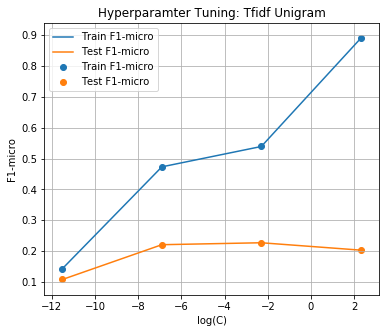


Best Score:  0.22711217970160913

Best params:  {'estimator__C': 0.1}

Time taken:  0:02:55.655800


In [21]:
# hyperparameter tuning of Tfidf unigram with LogisticRegression

start = datetime.now()
hyperparam_lr(X_train_uni, y_train, name='Tfidf Unigram')
print('\nTime taken: ', datetime.now() - start)

In [22]:
# trainig Logistic Regression with Tfidf unigram

start = datetime.now()
run_lr(X_train_uni, y_train, X_test_uni, y_test, best_param=0.1)
print('\nTime taken: ', datetime.now() - start)

Micro-Average metrics
Precision: 0.16, Recall: 0.42, F1-measure: 0.23

Metrics Report
              precision    recall  f1-score   support

           0       0.05      0.09      0.06        35
           1       0.14      0.51      0.22       117
           2       0.06      0.12      0.07        26
           3       0.07      0.18      0.10        11
           4       0.11      0.46      0.18        13
           5       0.02      0.08      0.03        26
           6       0.03      0.07      0.04        15
           7       0.06      0.28      0.10        75
           8       0.00      0.00      0.00         4
           9       0.04      0.06      0.05        31
          10       0.06      0.12      0.08         8
          11       0.04      0.10      0.05        20
          12       0.07      0.24      0.11        79
          13       0.06      0.22      0.10         9
          14       0.00      0.00      0.00         3
          15       0.06      0.13      0.08      

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   18.0s
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:   18.3s remaining:   55.1s
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:   18.9s remaining:   26.5s
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:   31.9s remaining:   22.7s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:   43.3s remaining:   14.4s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  1.3min finished


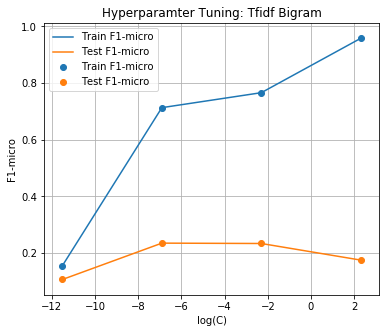


Best Score:  0.23522991315377365

Best params:  {'estimator__C': 0.001}

Time taken:  0:01:20.426548


In [25]:
# hyperparameter tuning of Tfidf bigram with LogisticRegression

start = datetime.now()
hyperparam_lr(X_train_bi, y_train, name='Tfidf Bigram')
print('\nTime taken: ', datetime.now() - start)

In [26]:
# Logsitic Regression for tfidf bigram 

start = datetime.now()
run_lr(X_train_bi, y_train, X_test_bi, y_test, best_param=0.001)
print('\nTime taken: ', datetime.now() - start)

Micro-Average metrics
Precision: 0.21, Recall: 0.33, F1-measure: 0.26

Metrics Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        35
           1       0.22      0.47      0.30       117
           2       0.00      0.00      0.00        26
           3       0.00      0.00      0.00        11
           4       0.12      0.15      0.13        13
           5       0.21      0.19      0.20        26
           6       0.00      0.00      0.00        15
           7       0.08      0.21      0.12        75
           8       0.00      0.00      0.00         4
           9       0.09      0.03      0.05        31
          10       0.33      0.25      0.29         8
          11       0.00      0.00      0.00        20
          12       0.05      0.11      0.07        79
          13       0.00      0.00      0.00         9
          14       0.00      0.00      0.00         3
          15       0.00      0.00      0.00      

In [21]:
# let's combine both tfidf uni, bi and trigram and then try it out 

X_tr_uni_bi_tri = hstack((X_train_uni, X_train_bi, X_train_tri)).tocsr()
X_te_uni_bi_tri = hstack((X_test_uni, X_test_bi, X_test_tri)).tocsr()

print('After combining all tfidf uni, bi and trigram are: \n')
print('X_train shape: {0} y_train shape: {1}'.format(X_tr_uni_bi_tri.shape, y_train.shape))
print('X_test shape: {0} y_test shape: {1}'.format(X_te_uni_bi_tri.shape, y_test.shape))

After combining all tfidf uni, bi and trigram are: 

X_train shape: (11862, 38096) y_train shape: (11862, 142)
X_test shape: (2966, 38096) y_test shape: (2966, 142)


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:  1.1min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:  1.1min remaining:  1.6min
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:  1.9min remaining:  1.4min
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:  2.8min remaining:   55.4s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  4.1min finished


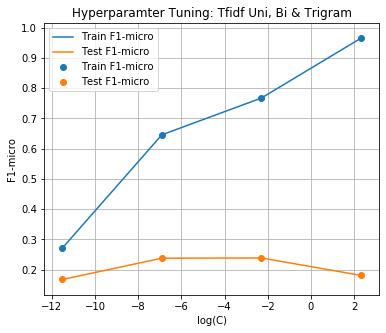


Best Score:  0.23873819685439576

Best params:  {'estimator__C': 0.1}

Time taken:  0:04:35.787133


In [28]:
# hyperparameter tuning of Tfidf unigram, bigram and trigram with LogisticRegression

start = datetime.now()
hyperparam_lr(X_tr_uni_bi_tri, y_train, name='Tfidf Uni, Bi & Trigram')
print('\nTime taken: ', datetime.now() - start)

In [29]:
# training tfidf uni, bi and tri gram on LogisticRegression

start = datetime.now()
run_lr(X_tr_uni_bi_tri, y_train, X_te_uni_bi_tri, y_test, best_param=0.1)
print('\nTime taken: ', datetime.now() - start)

Micro-Average metrics
Precision: 0.24, Recall: 0.32, F1-measure: 0.27

Metrics Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        35
           1       0.20      0.39      0.26       117
           2       0.18      0.08      0.11        26
           3       0.00      0.00      0.00        11
           4       0.17      0.15      0.16        13
           5       0.16      0.12      0.13        26
           6       0.00      0.00      0.00        15
           7       0.08      0.12      0.10        75
           8       0.00      0.00      0.00         4
           9       0.09      0.03      0.05        31
          10       0.33      0.12      0.18         8
          11       0.00      0.00      0.00        20
          12       0.10      0.11      0.11        79
          13       0.00      0.00      0.00         9
          14       0.00      0.00      0.00         3
          15       0.00      0.00      0.00      

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:   48.1s remaining:  2.4min
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:   49.0s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:  1.3min remaining:   53.6s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:  2.1min remaining:   41.7s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  3.3min finished


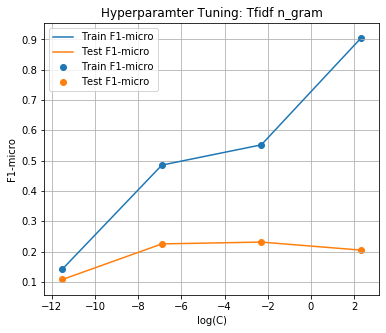


Best Score:  0.2312068286977151

Best params:  {'estimator__C': 0.1}

Time taken:  0:03:38.075331


In [30]:
# hyperparameter tuning of Tfidf n_gram with LogisticRegression

start = datetime.now()
hyperparam_lr(X_train_n_gram, y_train, name='Tfidf n_gram')
print('\nTime taken: ', datetime.now() - start)

In [33]:
# LR on tfidf n_gram

start = datetime.now()
run_lr(X_train_n_gram, y_train, X_test_n_gram, y_test, best_param=0.1)
print('\nTime taken: ', datetime.now() - start)

Micro-Average metrics
Precision: 0.17, Recall: 0.42, F1-measure: 0.24

Metrics Report
              precision    recall  f1-score   support

           0       0.05      0.09      0.06        35
           1       0.14      0.52      0.22       117
           2       0.06      0.12      0.07        26
           3       0.07      0.18      0.11        11
           4       0.12      0.46      0.19        13
           5       0.03      0.12      0.05        26
           6       0.03      0.07      0.05        15
           7       0.06      0.27      0.10        75
           8       0.00      0.00      0.00         4
           9       0.04      0.06      0.05        31
          10       0.06      0.12      0.08         8
          11       0.04      0.10      0.06        20
          12       0.06      0.22      0.10        79
          13       0.07      0.22      0.10         9
          14       0.00      0.00      0.00         3
          15       0.07      0.13      0.10      

In [22]:
#combining sentiments with our uni, bi and trigram

X_tr_ubt_sent = hstack((X_tr_uni_bi_tri, X_train_sent)).tocsr()
X_te_ubt_sent = hstack((X_te_uni_bi_tri, X_test_sent)).tocsr()

print('After combining all tfidf uni, bi and trigram and sentiments are: \n')
print('X_train shape: {0} y_train shape: {1}'.format(X_tr_ubt_sent.shape, y_train.shape))
print('X_test shape: {0} y_test shape: {1}'.format(X_te_ubt_sent.shape, y_test.shape))

After combining all tfidf uni, bi and trigram and sentiments are: 

X_train shape: (11862, 38122) y_train shape: (11862, 142)
X_test shape: (2966, 38122) y_test shape: (2966, 142)


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:  6.9min remaining: 20.7min
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed: 18.8min remaining: 26.3min
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed: 19.1min remaining: 13.6min
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed: 22.4min remaining:  7.5min
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 24.0min finished


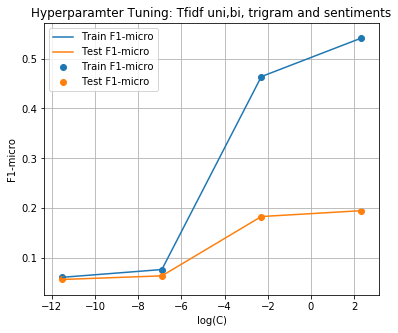


Best Score:  0.19512426355811774

Best params:  {'estimator__C': 10}

Time taken:  0:27:29.113895


In [23]:
# hyperparameter tuning of Tfidf uni, bi, Trigram with sentiments on LogisticRegression

start = datetime.now()
hyperparam_lr(X_tr_ubt_sent, y_train, name='Tfidf uni,bi, trigram and sentiments')
print('\nTime taken: ', datetime.now() - start)

In [24]:
# LR on tfidf uni, bi, trigram and sentiments
start = datetime.now()
run_lr(X_tr_ubt_sent, y_train, X_te_ubt_sent, y_test, best_param=10)
print('\nTime taken: ', datetime.now() - start)

Micro-Average metrics
Precision: 0.14, Recall: 0.38, F1-measure: 0.21

Metrics Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        35
           1       0.16      0.53      0.25       117
           2       0.05      0.08      0.06        26
           3       0.00      0.00      0.00        11
           4       0.04      0.15      0.06        13
           5       0.07      0.31      0.12        26
           6       0.00      0.00      0.00        15
           7       0.07      0.16      0.10        75
           8       0.00      0.00      0.00         4
           9       0.06      0.06      0.06        31
          10       0.14      0.12      0.13         8
          11       0.00      0.00      0.00        20
          12       0.07      0.16      0.09        79
          13       0.02      0.11      0.03         9
          14       0.00      0.00      0.00         3
          15       0.04      0.07      0.05      

## Observations -

- after looking at the scores till noe our combination of Tfidf uni, bi and trigram is giving the best result --> micro F1-Score of 27
- but in the research paper they are using only top 3 tags as the tags dataset is highly imbalanced 
we don't need to consider all unique tags 
- let's try two new things, SGDClassifier, we can check how this model performs compared to simple Logistic Regression
- we can also try LinearSVM using SGDClassifier using hinge loss and comapre that model as well
- lastly let's only predict for top 3 tags from our whole tags dataset
- the reason why we'll be taking top 3 tags is because as an average for each plot the tags are 2.9, as seen from EDA. check table for Tags above

In [26]:
movie_df_stem_lem['tags'] = back_to_string

In [27]:
# storing this df which conatins tags in string format into pickle

# movie_df_stem_lem.to_pickle('movie_df_str_tags.pkl')

movie_df_str_tags = pd.read_pickle('movie_df_str_tags.pkl')

movie_df_str_tags.head()

,imdb_id,title,plot_synopsis,split,synopsis_source,tags
0,tt0057603,I tre volti della paura,note synopsi orgin italian releas segment cert...,train,imdb,"cult, horror, gothic, murder, atmospheric"
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,two thousand year ago nhagruul foul sorcer rev...,train,imdb,violence
2,tt0033045,The Shop Around the Corner,matuschek gift store budapest workplac alfr kr...,test,imdb,romantic
3,tt0113862,Mr. Holland's Opus,glenn holland morn person anyon standard woken...,train,imdb,"inspiring, romantic, stupid, feel-good"
4,tt0086250,Scarface,may cuban man name toni montana al pacino clai...,val,imdb,"cruelty, murder, dramatic, cult, violence, atm..."


In [28]:
X_train_tags = movie_df_str_tags.loc[(movie_df_str_tags.split == 'train') | (movie_df_str_tags.split == 'val')]
X_test_tags = movie_df_str_tags.loc[(movie_df_str_tags.split == 'test')]

In [29]:
X_train_tags.head()

,imdb_id,title,plot_synopsis,split,synopsis_source,tags
0,tt0057603,I tre volti della paura,note synopsi orgin italian releas segment cert...,train,imdb,"cult, horror, gothic, murder, atmospheric"
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,two thousand year ago nhagruul foul sorcer rev...,train,imdb,violence
3,tt0113862,Mr. Holland's Opus,glenn holland morn person anyon standard woken...,train,imdb,"inspiring, romantic, stupid, feel-good"
4,tt0086250,Scarface,may cuban man name toni montana al pacino clai...,val,imdb,"cruelty, murder, dramatic, cult, violence, atm..."
5,tt1315981,A Single Man,georg falcon colin firth approach car accid mi...,val,imdb,"romantic, queer, flashback"


## Top 3 tags 

<img src='tags_in_paper.png'>

## Obseravations-

- we use CountVectorizer for the above job 
- we use max_features parameter and set it to 3 for top 3 tags from our tags

In [30]:
# creating top 3 tags y train, test data

vectorizer = CountVectorizer(tokenizer = lambda x: x.split(','), binary='true', max_features = 3)
y_train_3 = vectorizer.fit_transform(X_train_tags.tags)
y_test_3 = vectorizer.transform(X_test_tags.tags)

- Now let's look at our shape of X and y for train and test after top 3 tags 

In [31]:
print('Current shape of X_train: {0}, y_train: {1}'.format(X_train_tags.shape, y_train_3.shape))
print('Current shape of X_test: {0}, y_test: {1}'.format(X_test_tags.shape, y_test_3.shape))

Current shape of X_train: (11862, 6), y_train: (11862, 3)
Current shape of X_test: (2966, 6), y_test: (2966, 3)


## Modelling on Top 3 tags 

### Using SGDClassifier with log and hinge loss 

In [46]:
def run_sgd_log(x_train_data, y_train_data, x_test_data, y_test_data, best_param):
    '''
        SGDClassifier with log loss
    '''
    clf_log = OneVsRestClassifier(SGDClassifier(loss='log', alpha=best_param, penalty='l2', 
                                                   class_weight="balanced"), n_jobs=-1)
    clf_log.fit(x_train_data, y_train_data)
    y_test_pred = clf_log.predict(x_test_data)
    
    precision = precision_score(y_test_data, y_test_pred, average='micro')
    recall = recall_score(y_test_data, y_test_pred, average='micro')
    f1 = f1_score(y_test_data, y_test_pred, average='micro')
    
    print("Micro-Average metrics")
    print("Precision: {0}, Recall: {1}, F1-measure: {2}".format(round(precision, 2), round(recall, 2), 
                                                            round(f1, 2)))
    
    print('\nMetrics Report')
    print (classification_report(y_test_data, y_test_pred))

In [52]:
def run_sgd_hinge(x_train_data, y_train_data, x_test_data, y_test_data, best_param):
    '''
        SGDClassifier with hinge loss
    '''
    clf_hinge = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=best_param, penalty='l2', 
                                                   class_weight="balanced"), n_jobs=-1)
    clf_hinge.fit(x_train_data, y_train_data)
    
    y_test_pred = clf_hinge.predict(x_test_data)
    
    precision = precision_score(y_test_data, y_test_pred, average='micro')
    recall = recall_score(y_test_data, y_test_pred, average='micro')
    f1 = f1_score(y_test_data, y_test_pred, average='micro')
    
    print("Micro-Average metrics")
    print("Precision: {0}, Recall: {1}, F1-measure: {2}".format(round(precision, 2), round(recall, 2), 
                                                            round(f1, 2)))
    
    print('\nMetrics Report')
    print (classification_report(y_test_data, y_test_pred))
    

In [40]:
def hyperparam_sgd_log(train_data, y_train_data, name):
    '''
        GridSearchCV Hyperparameter tuning of SGDClassifier with log loss
    '''
    classifier = OneVsRestClassifier(SGDClassifier(loss='log', penalty='l2', class_weight="balanced" ))

    params = {"estimator__alpha": [10**-5, 10**-3, 10**-1, 10**1]}
    
    gs_sgd = GridSearchCV(classifier, param_grid=params, cv = 3, scoring='f1_micro', verbose=10, 
                     n_jobs=-1, return_train_score=True)
    gs_sgd.fit(train_data, y_train_data)
    
    results = pd.DataFrame.from_dict(gs_sgd.cv_results_)
    results = results.sort_values(['param_estimator__alpha'])
    
    train_f1 = results.mean_train_score
    test_f1 = results.mean_test_score
    param_alpha = results.param_estimator__alpha
    
    plt.figure(figsize=(6, 5))
    plt.plot(np.log(param_alpha.astype(float)), train_f1, label='Train F1-micro')
    plt.plot(np.log(param_alpha.astype(float)), test_f1, label='Test F1-micro')
    
    plt.scatter(np.log(param_alpha.astype(float)), train_f1, label='Train F1-micro')
    plt.scatter(np.log(param_alpha.astype(float)), test_f1, label='Test F1-micro')
    plt.legend()
    plt.title('Hyperparamter Tuning: {0}'.format(str(name)))
    plt.xlabel('log(C)')
    plt.ylabel('F1-micro')
    plt.grid()
    plt.show()
    
    print('\nBest Score: ', gs_sgd.best_score_)
    print('\nBest params: ', gs_sgd.best_params_)

In [39]:
def hyperparam_sgd_hinge(train_data, y_train_data, name):
    '''
        GridSearchCV Hyperparameter tuning of SGDClassifier with log loss
    '''
    classifier = OneVsRestClassifier(SGDClassifier(loss='hinge', penalty='l2', class_weight="balanced" ))

    params = {"estimator__alpha": [10**-5, 10**-3, 10**-1, 10**1]}
    
    gs_sgd = GridSearchCV(classifier, param_grid=params, cv = 3, scoring='f1_micro', verbose=10, 
                     n_jobs=-1, return_train_score=True)
    gs_sgd.fit(train_data, y_train_data)
    
    results = pd.DataFrame.from_dict(gs_sgd.cv_results_)
    results = results.sort_values(['param_estimator__alpha'])
    
    train_f1 = results.mean_train_score
    test_f1 = results.mean_test_score
    param_alpha = results.param_estimator__alpha
    
    plt.figure(figsize=(6, 5))
    plt.plot(np.log(param_alpha.astype(float)), train_f1, label='Train F1-micro')
    plt.plot(np.log(param_alpha.astype(float)), test_f1, label='Test F1-micro')
    
    plt.scatter(np.log(param_alpha.astype(float)), train_f1, label='Train F1-micro')
    plt.scatter(np.log(param_alpha.astype(float)), test_f1, label='Test F1-micro')
    plt.legend()
    plt.title('Hyperparamter Tuning: {0}'.format(str(name)))
    plt.xlabel('log(C)')
    plt.ylabel('F1-micro')
    plt.grid()
    plt.show()
    
    print('\nBest Score: ', gs_sgd.best_score_)
    print('\nBest params: ', gs_sgd.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    2.9s remaining:    8.9s
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    3.0s remaining:    4.2s
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:    3.2s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    3.4s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    3.5s finished


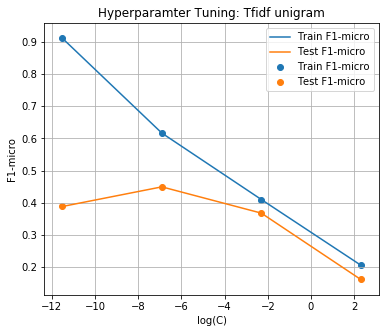


Best Score:  0.4493988006255645

Best params:  {'estimator__alpha': 0.001}

Time taken:  0:00:04.847348


In [41]:
# hyperparameter tuning of Tfidf unigram on SGD_log

start = datetime.now()
hyperparam_sgd_log(X_train_uni, y_train_3, name='Tfidf unigram')
print('\nTime taken: ', datetime.now() - start)

In [47]:
# SGD_log on tfidf unigram

start = datetime.now()
run_sgd_log(X_train_uni, y_train_3, X_test_uni, y_test_3, best_param=0.001)
print('\nTime taken: ', datetime.now() - start)

Micro-Average metrics
Precision: 0.38, Recall: 0.62, F1-measure: 0.47

Metrics Report
              precision    recall  f1-score   support

           0       0.25      0.49      0.33       515
           1       0.50      0.66      0.57       885
           2       0.37      0.67      0.47       593

   micro avg       0.38      0.62      0.47      1993
   macro avg       0.37      0.61      0.46      1993
weighted avg       0.40      0.62      0.48      1993
 samples avg       0.21      0.26      0.22      1993


Time taken:  0:00:00.675978


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    1.6s remaining:    4.9s
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    1.7s remaining:    2.4s
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:    1.9s remaining:    1.3s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    2.1s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    2.4s finished


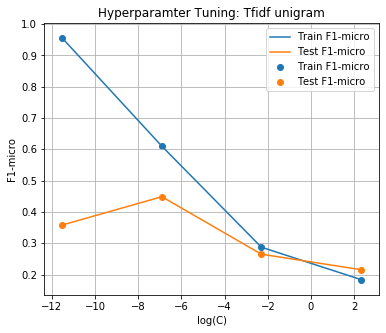


Best Score:  0.448539396245669

Best params:  {'estimator__alpha': 0.001}

Time taken:  0:00:03.767150


In [48]:
# hyperparameter tuning of Tfidf unigram on SGD_hinge

start = datetime.now()
hyperparam_sgd_hinge(X_train_uni, y_train_3, name='Tfidf unigram')
print('\nTime taken: ', datetime.now() - start)

In [53]:
# SGD_hinge on tfidf unigram

start = datetime.now()
run_sgd_hinge(X_train_uni, y_train_3, X_test_uni, y_test_3, best_param=0.001)
print('\nTime taken: ', datetime.now() - start)

Micro-Average metrics
Precision: 0.39, Recall: 0.6, F1-measure: 0.47

Metrics Report
              precision    recall  f1-score   support

           0       0.26      0.44      0.33       515
           1       0.50      0.65      0.57       885
           2       0.37      0.66      0.47       593

   micro avg       0.39      0.60      0.47      1993
   macro avg       0.38      0.59      0.46      1993
weighted avg       0.40      0.60      0.48      1993
 samples avg       0.21      0.25      0.21      1993


Time taken:  0:00:00.611239


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    2.8s remaining:    8.7s
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    4.3s remaining:    6.0s
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:    4.5s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    6.5s remaining:    2.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    6.8s finished


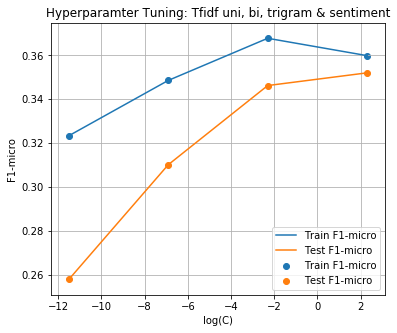


Best Score:  0.3520609477578855

Best params:  {'estimator__alpha': 10}

Time taken:  0:00:08.478559


In [61]:
# hyperparameter tuning of Tfidf uni, bi, Trigram and sentiments on SGD_log

start = datetime.now()
hyperparam_sgd_log(X_tr_ubt_sent, y_train_3, name='Tfidf uni, bi, trigram & sentiment')
print('\nTime taken: ', datetime.now() - start)

In [62]:
# SGD_log on tfidf uni, bi, trigram and sentiments

start = datetime.now()
run_sgd_log(X_tr_ubt_sent, y_train_3, X_te_ubt_sent, y_test_3, best_param=10)
print('\nTime taken: ', datetime.now() - start)

Micro-Average metrics
Precision: 0.23, Recall: 0.94, F1-measure: 0.37

Metrics Report
              precision    recall  f1-score   support

           0       0.17      1.00      0.30       515
           1       0.32      0.88      0.47       885
           2       0.21      0.97      0.35       593

   micro avg       0.23      0.94      0.37      1993
   macro avg       0.23      0.95      0.37      1993
weighted avg       0.25      0.94      0.39      1993
 samples avg       0.22      0.41      0.27      1993


Time taken:  0:00:00.748547


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    3.1s remaining:    9.4s
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    3.3s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:    4.3s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    5.0s remaining:    1.6s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    5.3s finished


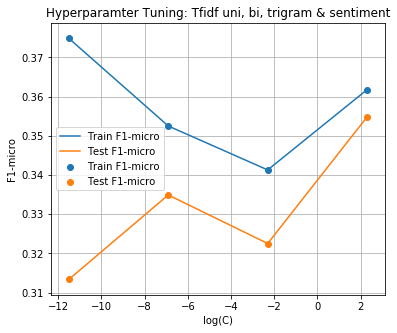


Best Score:  0.3548392598975931

Best params:  {'estimator__alpha': 10}

Time taken:  0:00:06.816817


In [58]:
# hyperparameter tuning of Tfidf uni, bi, Trigram and sentiments on SGD_hinge

start = datetime.now()
hyperparam_sgd_hinge(X_tr_ubt_sent, y_train_3, name='Tfidf uni, bi, trigram & sentiment')
print('\nTime taken: ', datetime.now() - start)

In [60]:
# SGD_hinge on tfidf uni, bi, trigram and sentiments

start = datetime.now()
run_sgd_hinge(X_tr_ubt_sent, y_train_3, X_te_ubt_sent, y_test_3, best_param=10)
print('\nTime taken: ', datetime.now() - start)

Micro-Average metrics
Precision: 0.23, Recall: 0.96, F1-measure: 0.37

Metrics Report
              precision    recall  f1-score   support

           0       0.17      1.00      0.30       515
           1       0.32      0.91      0.47       885
           2       0.21      0.99      0.34       593

   micro avg       0.23      0.96      0.37      1993
   macro avg       0.23      0.97      0.37      1993
weighted avg       0.25      0.96      0.39      1993
 samples avg       0.22      0.41      0.28      1993


Time taken:  0:00:00.737159


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    1.2s remaining:    3.8s
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    1.3s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:    1.5s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    1.6s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    1.9s finished


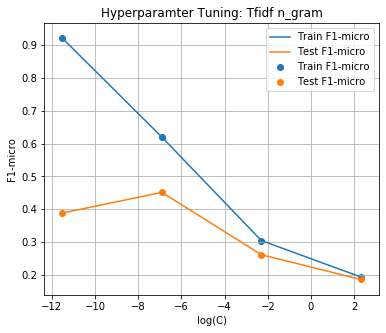


Best Score:  0.45148264959510187

Best params:  {'estimator__alpha': 0.001}

Time taken:  0:00:03.151474


In [63]:
# hyperparameter tuning of n_gram on SGD_log

start = datetime.now()
hyperparam_sgd_log(X_train_n_gram, y_train_3, name='Tfidf n_gram')
print('\nTime taken: ', datetime.now() - start)

In [64]:
# SGD_log on tfidf n_gram

start = datetime.now()
run_sgd_log(X_train_n_gram, y_train_3, X_test_n_gram, y_test_3, best_param=0.001)
print('\nTime taken: ', datetime.now() - start)

Micro-Average metrics
Precision: 0.38, Recall: 0.64, F1-measure: 0.48

Metrics Report
              precision    recall  f1-score   support

           0       0.26      0.51      0.34       515
           1       0.50      0.67      0.57       885
           2       0.37      0.69      0.48       593

   micro avg       0.38      0.64      0.48      1993
   macro avg       0.38      0.62      0.47      1993
weighted avg       0.40      0.64      0.49      1993
 samples avg       0.21      0.26      0.22      1993


Time taken:  0:00:00.638153


Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   3 out of  12 | elapsed:    1.1s remaining:    3.6s
[Parallel(n_jobs=-1)]: Done   5 out of  12 | elapsed:    1.7s remaining:    2.5s
[Parallel(n_jobs=-1)]: Done   7 out of  12 | elapsed:    1.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done   9 out of  12 | elapsed:    2.1s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    2.6s finished


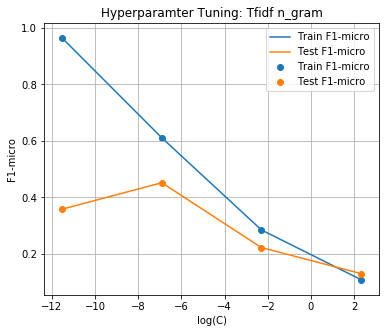


Best Score:  0.45194319032926744

Best params:  {'estimator__alpha': 0.001}

Time taken:  0:00:04.245281


In [66]:
# hyperparameter tuning of n_gram on SGD_hinge

start = datetime.now()
hyperparam_sgd_hinge(X_train_n_gram, y_train_3, name='Tfidf n_gram')
print('\nTime taken: ', datetime.now() - start)

In [67]:
# SGD_hinge on tfidf n_gram

start = datetime.now()
run_sgd_hinge(X_train_n_gram, y_train_3, X_test_n_gram, y_test_3, best_param=0.001)
print('\nTime taken: ', datetime.now() - start)

Micro-Average metrics
Precision: 0.39, Recall: 0.62, F1-measure: 0.48

Metrics Report
              precision    recall  f1-score   support

           0       0.26      0.47      0.34       515
           1       0.50      0.66      0.57       885
           2       0.37      0.68      0.48       593

   micro avg       0.39      0.62      0.48      1993
   macro avg       0.38      0.60      0.46      1993
weighted avg       0.40      0.62      0.48      1993
 samples avg       0.21      0.25      0.22      1993


Time taken:  0:00:00.727098


## Obseravtions:

- our SGDClassifier models are performing tremendously better than simple Logistic Regression models
- Since SGD_log and SGD_hinge are giving almost same results i am going to perform further experimentation with only SGD_log
- Till now our best micro-F1 Score = 48
- our model performance has already surpassed the Research Paper model performance which is micro-F1 Score of 37

<img src='research_result.png'>

# Conclusion-
- As we can see the micro F1 score for the models are 37.3 in the research paper my model performance is 48 with top 3 tags
- We have successfully solved the research paper and got great result 
- our best model is SGDClassifier with log loss using OneVsRestClassifier